# Data Exploration on Netflix Prize Data

## Initialize

### Import Libraries

In cause you face import error


> ImportError: cannot import name 'ABCIndexClass' from 'pandas.core.dtypes.generic' (c:\Users\johnn\anaconda3\envs\python39\lib\site-packages\pandas\core\dtypes\generic.py)
> Thanks to the @aflyingtoaster's answer, the following workaround has worked fine for me:
> 
> Edit the file "~/[your_conda_env_path]/lib/site-packages/visions/dtypes/boolean.py"
> Find the row "from pandas.core.dtypes.generic import ABCIndexClass, ABCSeries" and just replace ABCIndexClass for ABCIndex.
> Save the boolean.py file and enjoy your report!
> https://stackoverflow.com/questions/68704002/importerror-cannot-import-name-abcindexclass-from-pandas-core-dtypes-generic


In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%matplotlib inline
from scipy import stats
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set(font_scale=2)


In [2]:
# define the paths
data_path = '../data/NetflixPrize/'

### Read Data

In [3]:
df_test = pd.read_csv(data_path+'combined_data_1.txt',
                      names=['user_id', 'rating', 'date', 'movie_id'],
                      low_memory=False,
                      dtype={'user_id':str,
                             'rating':float,
                             'date':str,
                             'movie_id':float})
df_test_2 = pd.read_csv(data_path+'combined_data_2.txt',names=['user_id', 'rating', 'date', 'movie_id'],low_memory=False)
df_test_3 = pd.read_csv(data_path+'combined_data_3.txt',names=['user_id', 'rating', 'date', 'movie_id'],low_memory=False)
df_test_4 = pd.read_csv(data_path+'combined_data_4.txt',names=['user_id', 'rating', 'date', 'movie_id'],low_memory=False)
df_test = pd.concat([df_test,df_test_2,df_test_3,df_test_4])


### Understanding the data

In [4]:
print(df_test)
print(df_test.shape)
print(df_test.columns)
print(df_test.isnull().sum().iloc[1])

          user_id  rating        date  movie_id
0              1:     NaN         NaN       NaN
1         1488844     3.0  2005-09-06       NaN
2          822109     5.0  2005-05-13       NaN
3          885013     4.0  2005-10-19       NaN
4           30878     4.0  2005-12-26       NaN
...           ...     ...         ...       ...
26851921  1790158     4.0  2005-11-01       NaN
26851922  1608708     3.0  2005-07-19       NaN
26851923   234275     1.0  2004-08-07       NaN
26851924   255278     4.0  2004-05-28       NaN
26851925   453585     2.0  2005-03-10       NaN

[100498277 rows x 4 columns]
(100498277, 4)
Index(['user_id', 'rating', 'date', 'movie_id'], dtype='object')
17770


### Clean up data
From `df.head()`, we can see that the movies id are converted as `uid: movie_id` with `rating: NaN`, `date: NaN`, and `movie_id: NaN`, and the date haven't appeared. Therefore, we will modify the it to be 4 columns: `movie_id`, `user_id`, `rating`, `date`. By the value of `m_movies` in next section, we can see that `df_test.isnull().sum().iloc[1]==m_movies`, implies that there will be no null value in the data if we just change the lines with `movie_id:` as follow:

In [5]:
# Lets make a copy of the data first
import shutil
for i in range(1,5):
  shutil.copyfile(data_path+f'combined_data_{i}.txt',data_path+f'data_{i}.txt')
print('done')

done


In [6]:
# # Modify the the rows with 'movie_id:' to ',,,movie_id'
import re

pat = r'\d+:'
def func(s):
  if s.group():
    return ',,,'+ s.group()[:-1]
  else:
    ''

for i in range(1,5): 
  with open(data_path+f"data_{i}.txt", mode="r+") as f:
    content = f.read()
    content = re.sub(pat,func,content)
    f.seek(0)
    f.write(content)
    f.truncate()
    
print('done')

done


### Load the new data

In [3]:
names = ['user_id','rating','date','movie_id']
# load data (comment df_2, df_3, df_4 and last line if you want to reduce the loading time)
df = pd.read_csv(data_path+'data_1.txt', names=names)
df_2 = pd.read_csv(data_path+'data_2.txt', names=names)
df_3 = pd.read_csv(data_path+'data_3.txt', names=names)
df_4 = pd.read_csv(data_path+'data_4.txt', names=names)
df = pd.concat([df,df_2,df_3,df_4], names=names)

In [4]:
df['movie_id'] = df['movie_id'].fillna(method='ffill')

# drop the rows with NaN 
df = df.dropna()

# change the datatypes 
df['rating'] = df['rating'].astype(int)
df['movie_id'] = df['movie_id'].astype(int)
df['user_id'] = df['user_id'].astype(int)
df['date'] = pd.to_datetime(df['date'])

## Understanding the data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 1 to 26851925
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int32         
 1   rating    int32         
 2   date      datetime64[ns]
 3   movie_id  int32         
dtypes: datetime64[ns](1), int32(3)
memory usage: 2.6 GB


In [10]:
df.head()

,user_id,rating,date,movie_id
1,1488844,3,2005-09-06,1
2,822109,5,2005-05-13,1
3,885013,4,2005-10-19,1
4,30878,4,2005-12-26,1
5,823519,3,2004-05-03,1


In [11]:
df.tail()

,user_id,rating,date,movie_id
26851921,1790158,4,2005-11-01,17770
26851922,1608708,3,2005-07-19,17770
26851923,234275,1,2004-08-07,17770
26851924,255278,4,2004-05-28,17770
26851925,453585,2,2005-03-10,17770


In [12]:
print(f'(rows, columns): {df.shape}')

(rows, columns): (100480507, 4)


In [13]:
# Note that it is not necessary to know the mean, std,... of user_id, movie_id because they are continuous.
df['rating'].describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [14]:
print(f"The columns are {df.columns.values}.")

The columns are ['user_id' 'rating' 'date' 'movie_id'].


The columns are `['user_id', 'rating', 'date', 'movie_id']`.

In [15]:
print(f'The number of null data are {df.isnull().sum().sum()}.')

The number of null data are 0.


There is no null data in the data set now.

In [16]:
# Find the const values of the data and print it in the next cell.
m_movies = df['movie_id'].nunique()
n_users = df['user_id'].nunique()
n_ratings = len(df)
n_date = df['date'].nunique()
unique_rate = df['rating'].unique()

In [17]:
print("=== Const Values of the data ===")
print(f"Nnumber of movies: {m_movies}")
print(f"Number of users: {n_users}")
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique dates: {n_date}")
print(f"Users can rate movies with in {sorted(unique_rate)}")
print("=== End of Const Values of the data ===")

=== Const Values of the data ===
Nnumber of movies: 17770
Number of users: 480189
Number of ratings: 100480507
Number of unique dates: 2182
Users can rate movies with in [1, 2, 3, 4, 5]
=== End of Const Values of the data ===


## Relationship analysis

#### Correlation or each pair of data excluding the dataframe_index.

In [18]:
# get the correlation of each column.
correlation = df.corr()

<AxesSubplot:>

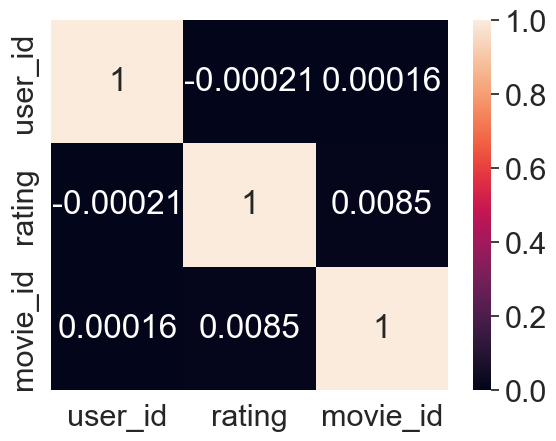

In [19]:
# visually show the correlation 
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns,annot=True)

#### Rating Analysis

In [20]:
df['rating'].describe()[1:]

mean    3.604290
std     1.085219
min     1.000000
25%     3.000000
50%     4.000000
75%     4.000000
max     5.000000
Name: rating, dtype: float64

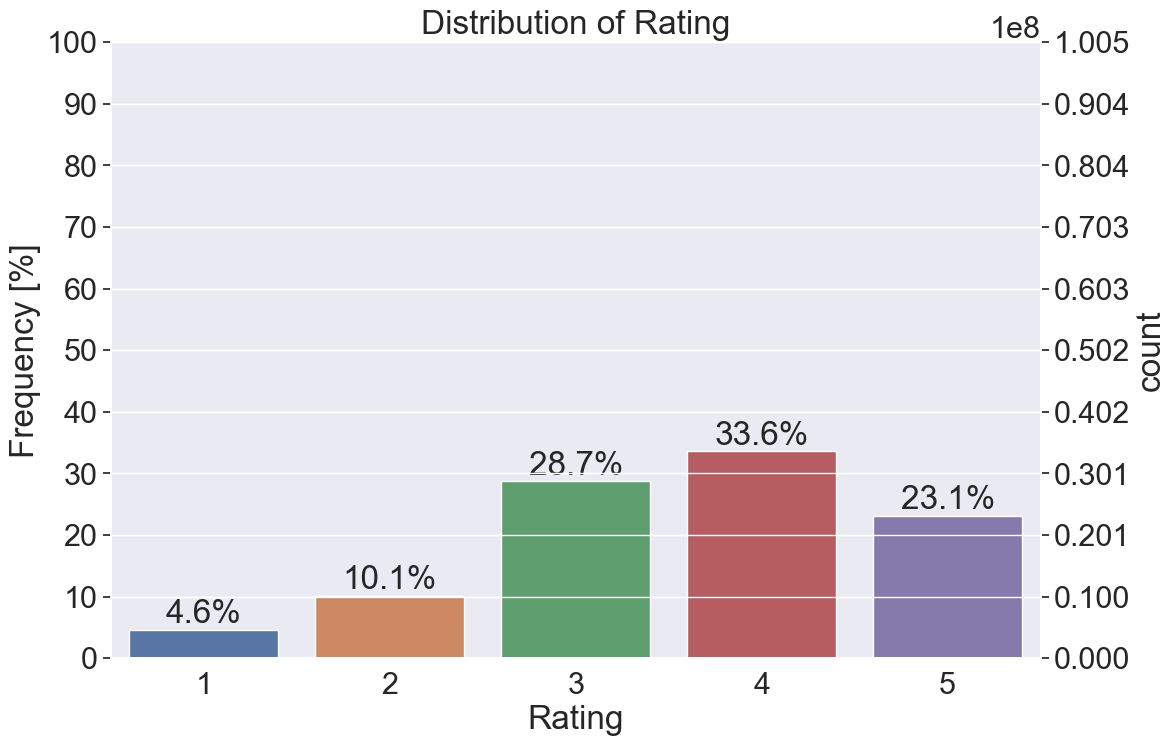

In [21]:
# plot the distribution of rating
plt.figure(figsize=(12,8))
ax = sns.countplot(x='rating', data=df)
plt.title('Distribution of Rating')
plt.xlabel('Rating')

ax2 = ax.twinx()

ax2.yaxis.tick_left()
ax.yaxis.tick_right()

ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
  x = p.get_bbox().get_points()[:,0]
  y = p.get_bbox().get_points()[1,1]
  ax.annotate('{:.1f}%'.format(100*y/n_ratings), (x.mean(), y), ha='center', va='bottom')

import matplotlib.ticker as ticker
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

ax2.set_ylim(0,100)
ax.set_ylim(0, n_ratings)

ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# ax2.grid(None)
plt.show()

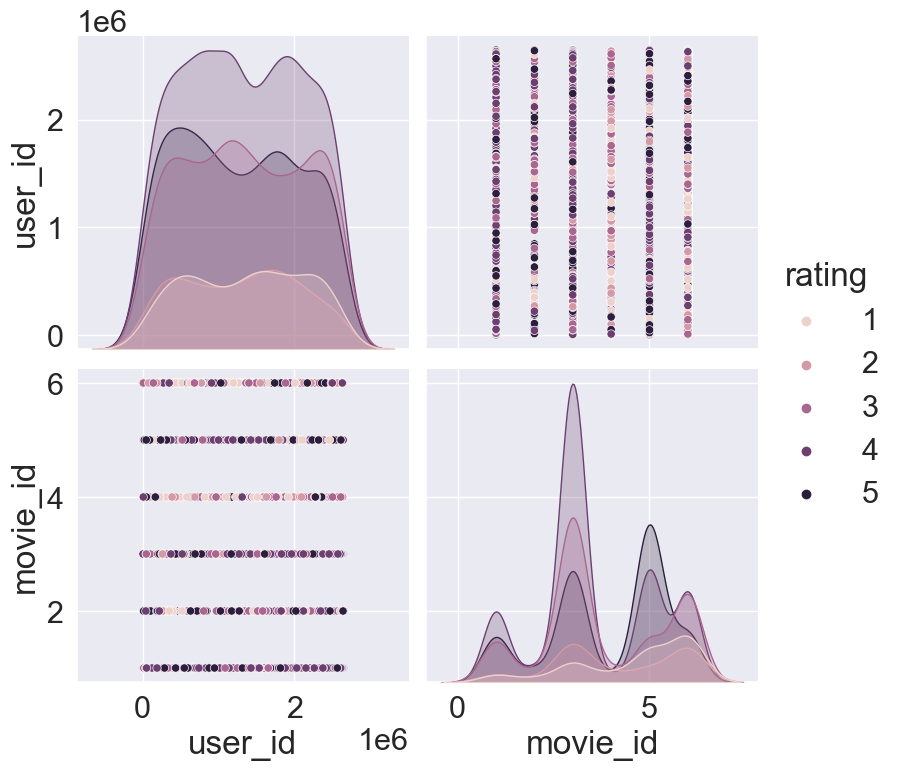

In [22]:
# generate the pair plot of the data set, [:5000] because the data set is too large.
sns.pairplot(data=df[:5000],hue='rating',height=4)

In [23]:
# group the data by user, movie, and date
group_by_user = df.groupby('user_id')
group_by_movie = df.groupby('movie_id')
group_by_date = df.groupby('date')

In [24]:
# get the count of rating from the group
user = group_by_user['rating'].count()
movie = group_by_movie['rating'].count()
date = group_by_date['rating'].count()

C:\Users\johnn\AppData\Local\Temp\ipykernel_3552\313240946.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


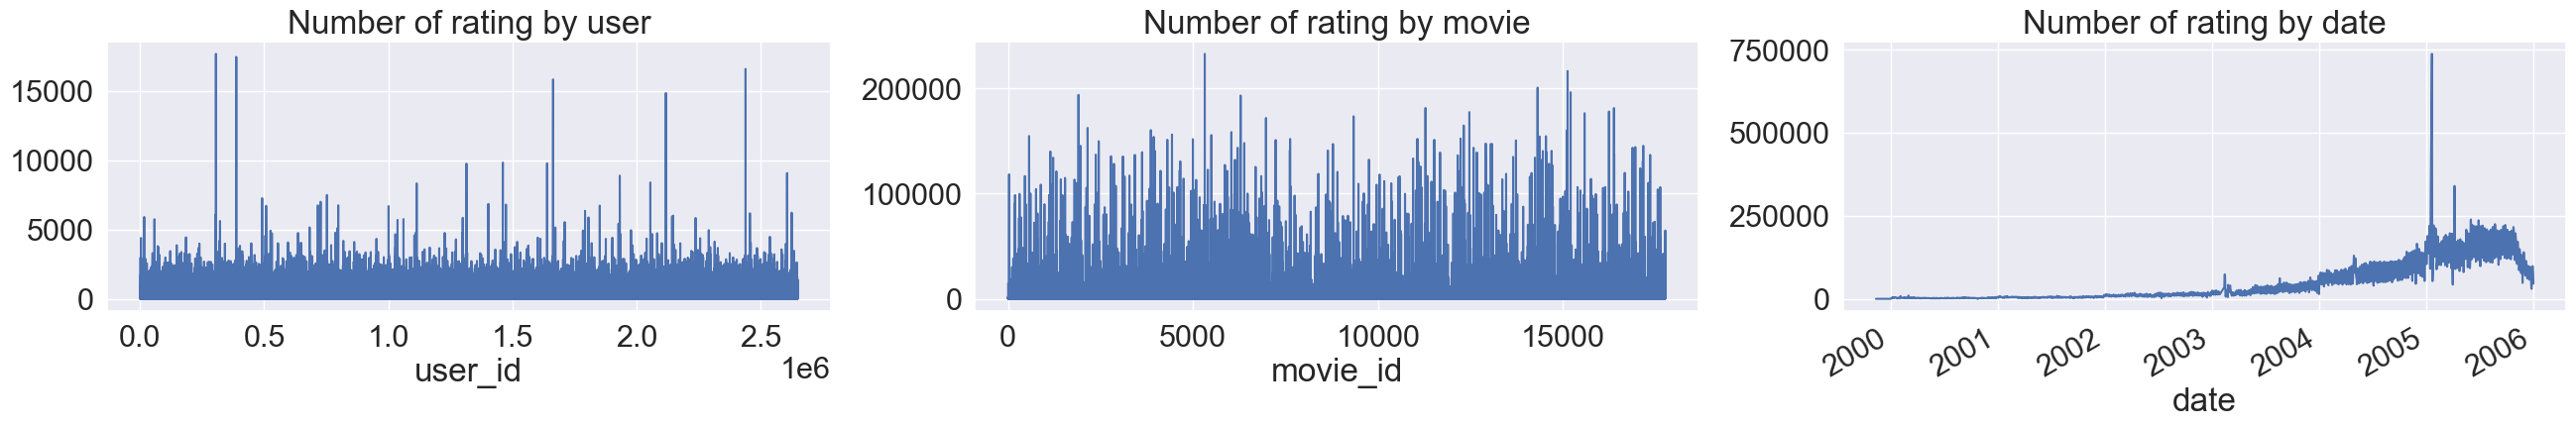

In [25]:
# plot the line graph of each counting in group
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(32,4))

user.plot(ax=ax[0])
movie.plot(ax=ax[1])
date.plot(ax=ax[2])

ax[0].set_title('Number of rating by user')
ax[1].set_title('Number of rating by movie')
ax[2].set_title('Number of rating by date')

fig.show()

In [26]:
# a function to remove the outliers
def remove_outlier(df:pd.Series):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  _df = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
  return df[_df]

C:\Users\johnn\AppData\Local\Temp\ipykernel_3552\3797969660.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


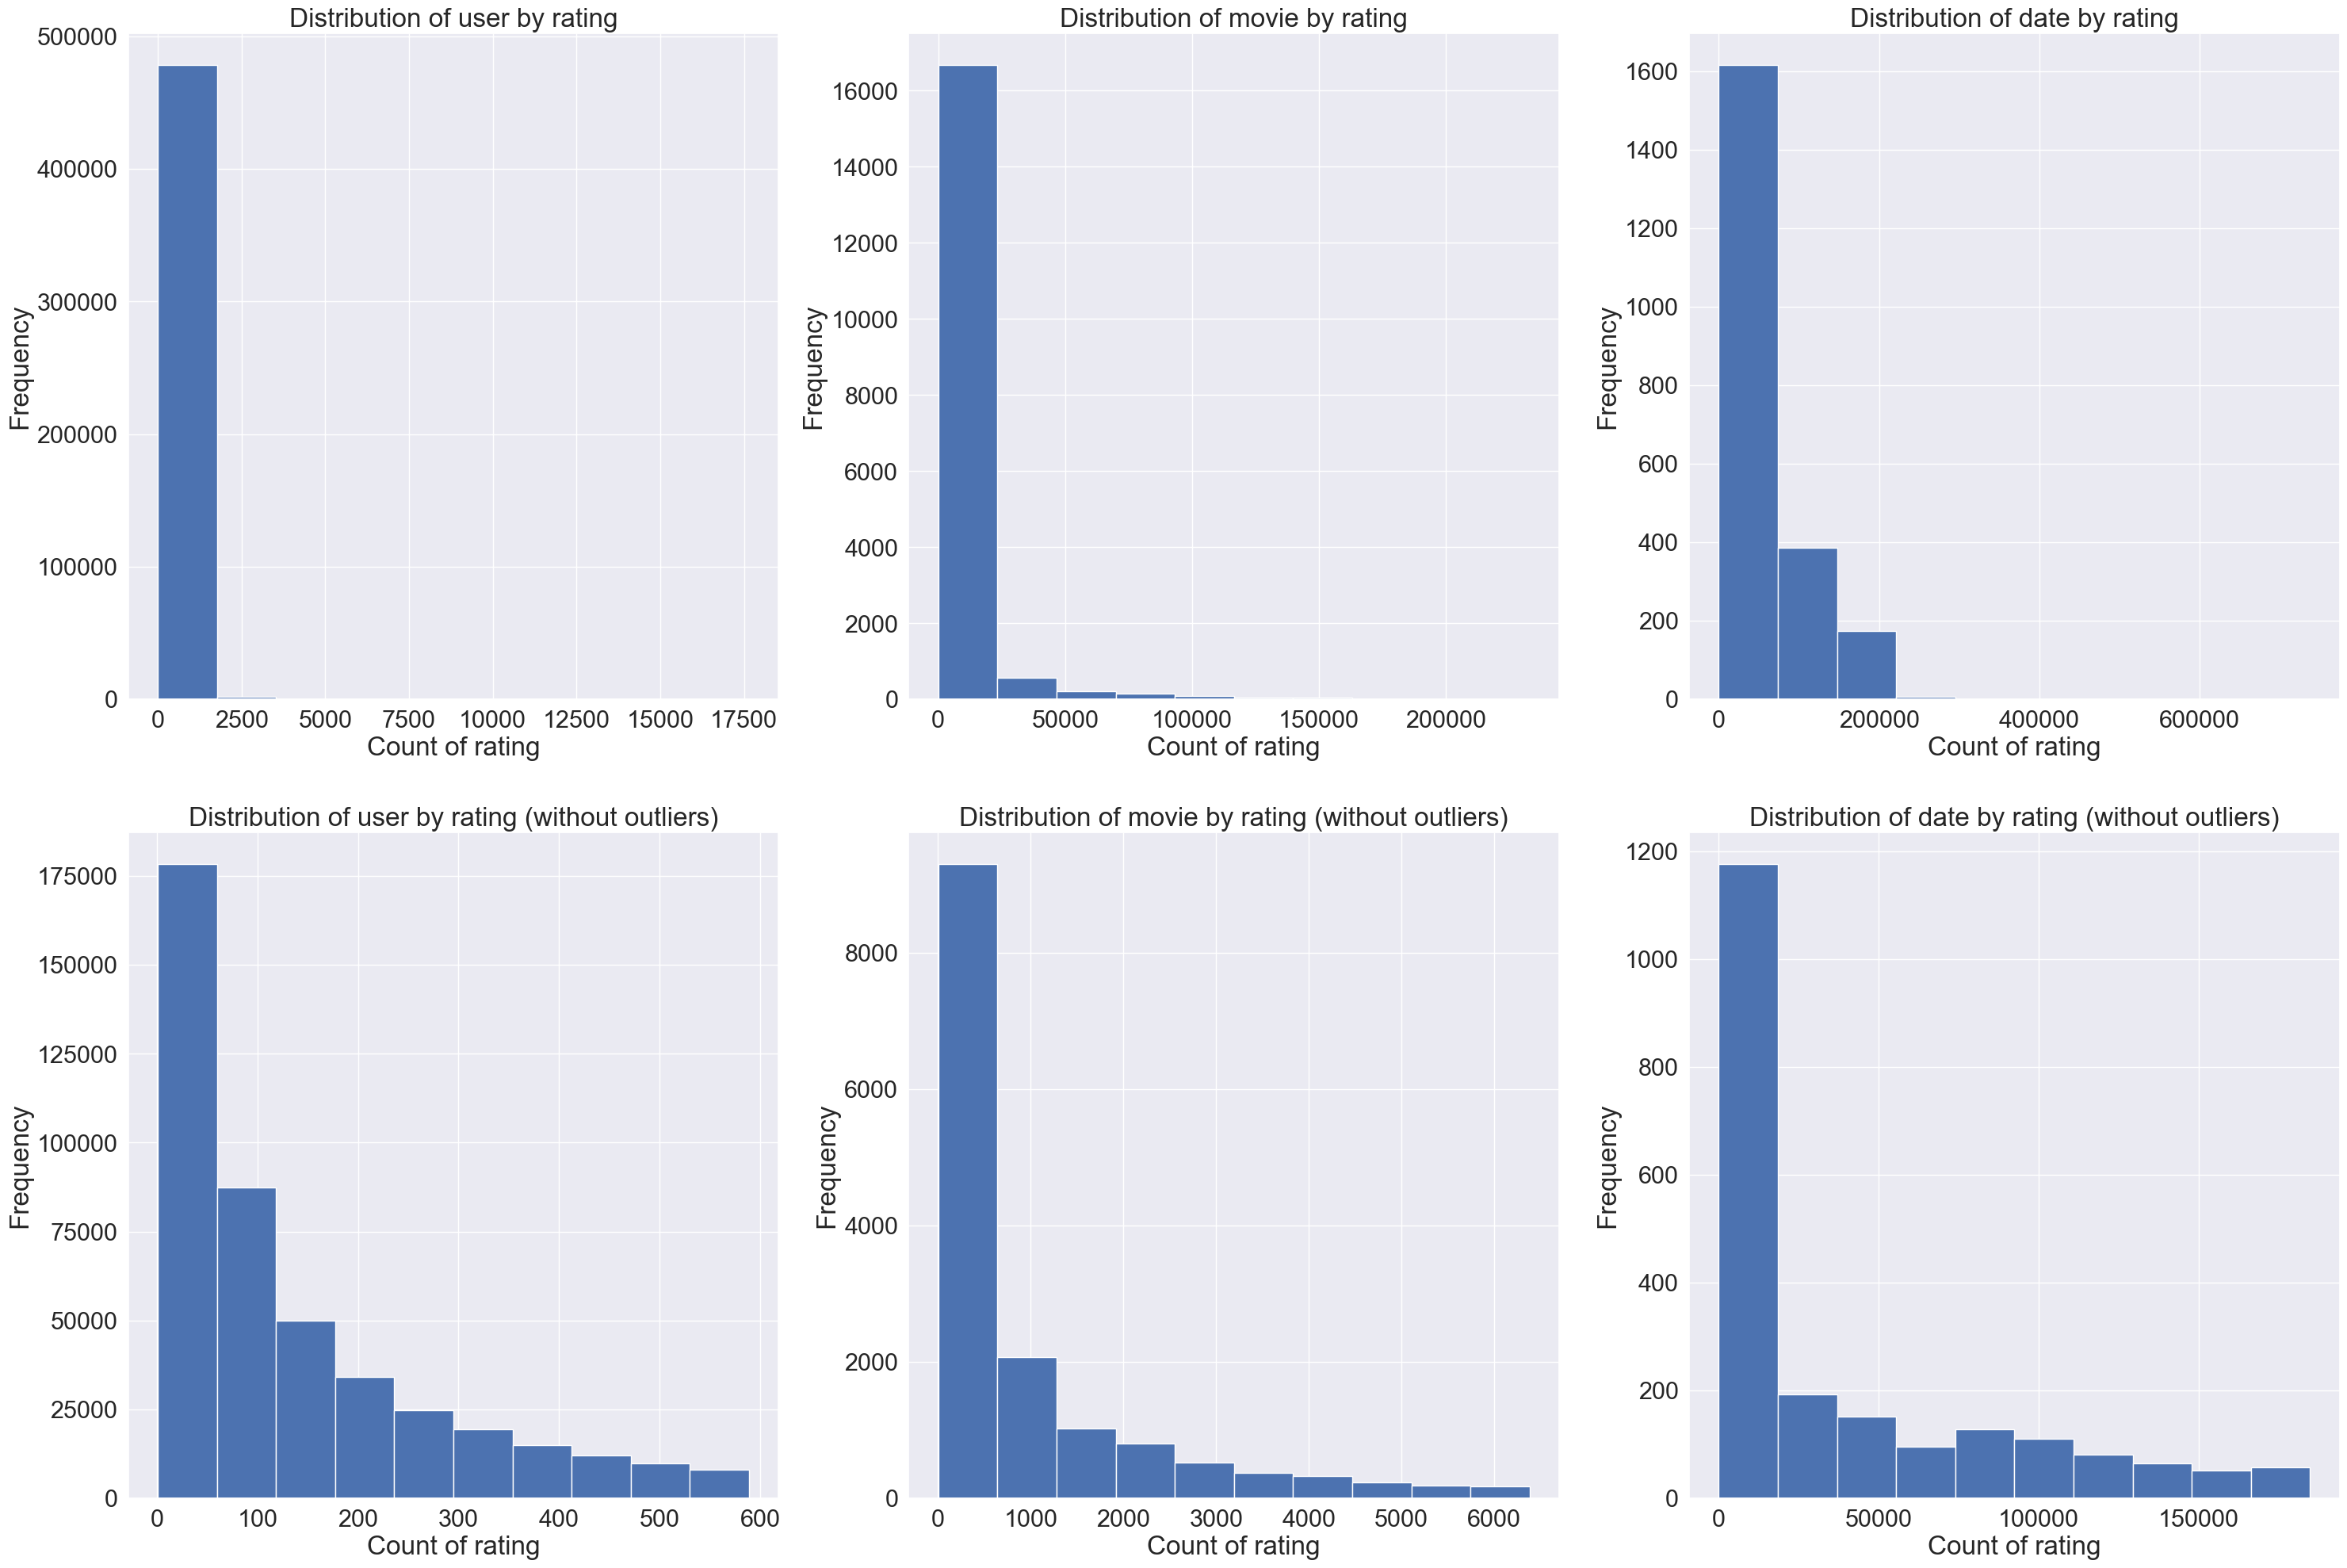

In [27]:
# plot the histogram fo these
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(36,24))

user.plot.hist(ax=ax[0,0])
movie.plot.hist(ax=ax[0,1])
date.plot.hist(ax=ax[0,2])

remove_outlier(user).plot.hist(ax=ax[1,0])
remove_outlier(movie).plot.hist(ax=ax[1,1])
remove_outlier(date).plot.hist(ax=ax[1,2])

ax[0,0].set_title('Distribution of user by rating')
ax[0,1].set_title('Distribution of movie by rating')
ax[0,2].set_title('Distribution of date by rating')
ax[0,0].set(xlabel='Count of rating')
ax[0,1].set(xlabel='Count of rating')
ax[0,2].set(xlabel='Count of rating')

ax[1,0].set_title('Distribution of user by rating (without outliers)')
ax[1,1].set_title('Distribution of movie by rating (without outliers)')
ax[1,2].set_title('Distribution of date by rating (without outliers)')
ax[1,0].set(xlabel='Count of rating')
ax[1,1].set(xlabel='Count of rating')
ax[1,2].set(xlabel='Count of rating')


fig.show()

C:\Users\johnn\AppData\Local\Temp\ipykernel_3552\1725877758.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


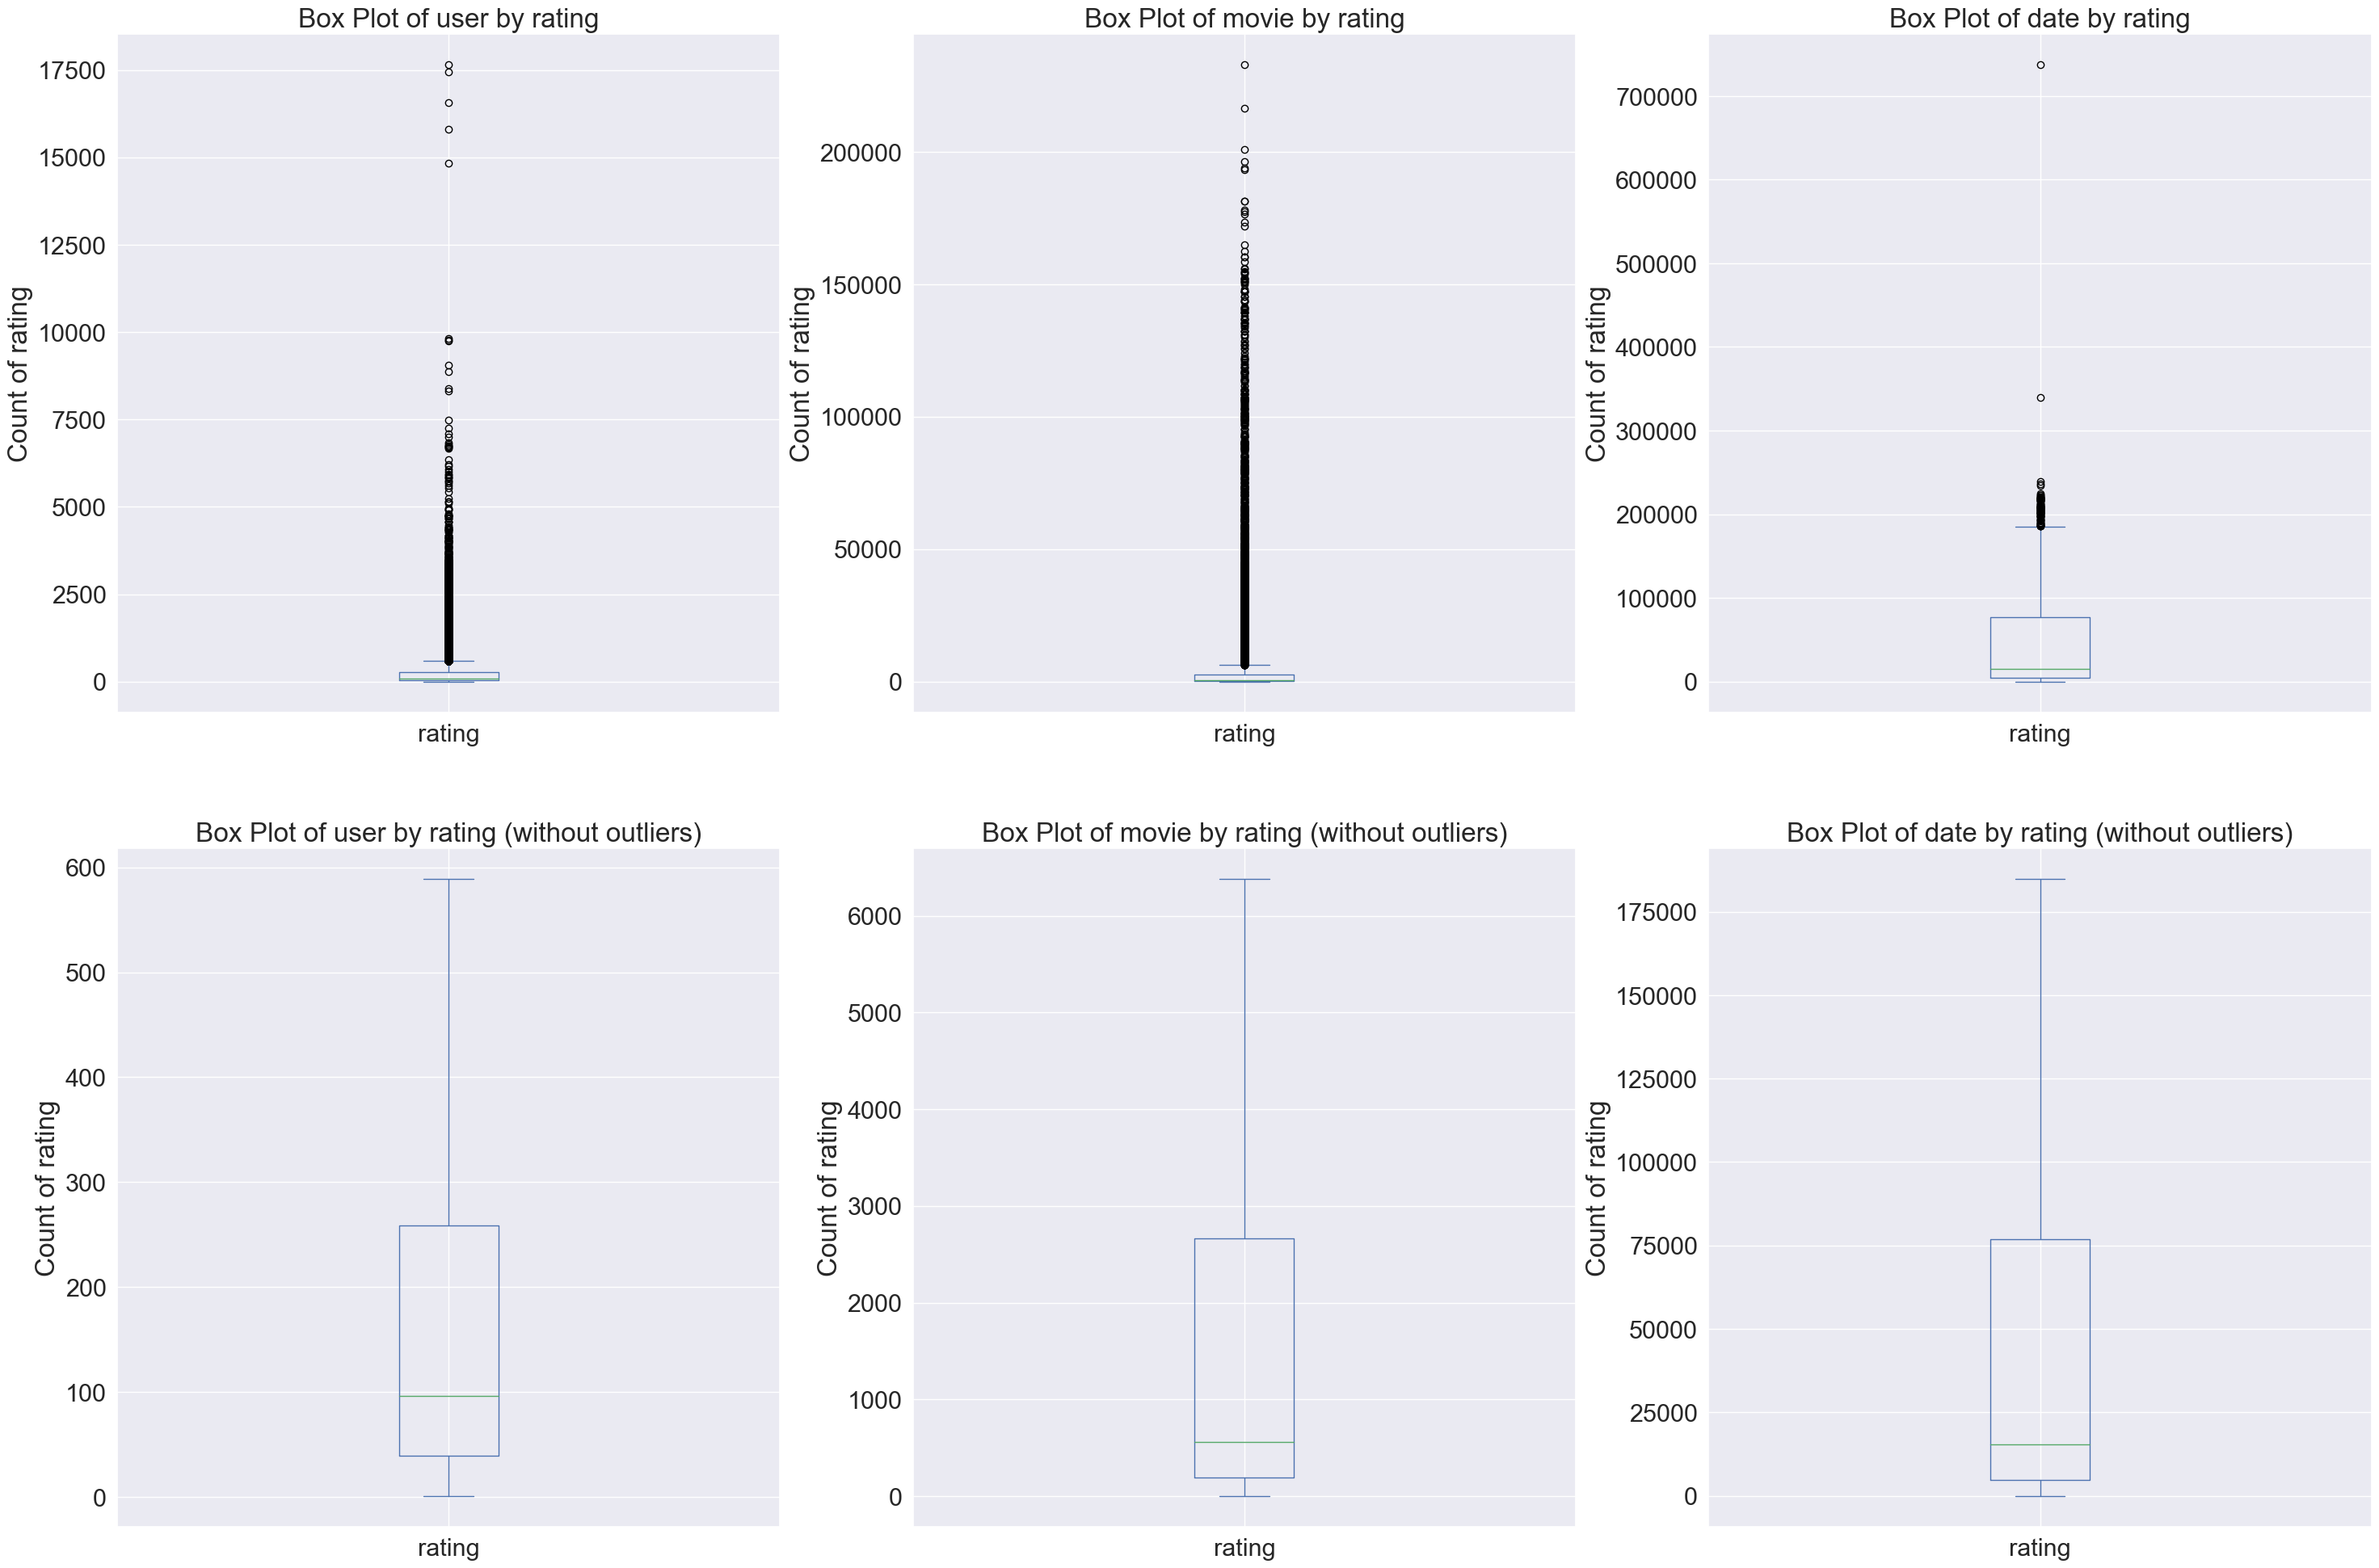

In [28]:
# plot the box graph of these
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(36,24))

user.plot.box(ax=ax[0,0])
movie.plot.box(ax=ax[0,1])
date.plot.box(ax=ax[0,2])


user.plot.box(ax=ax[1,0],showfliers=False)
movie.plot.box(ax=ax[1,1],showfliers=False)
date.plot.box(ax=ax[1,2],showfliers=False)

# remove_outlier(user).plot.box(ax=ax[1,0])
# remove_outlier(movie).plot.box(ax=ax[1,1])
# remove_outlier(date).plot.box(ax=ax[1,2])

ax[0,0].set_title('Box Plot of user by rating')
ax[0,1].set_title('Box Plot of movie by rating')
ax[0,2].set_title('Box Plot of date by rating')
ax[0,0].set(ylabel='Count of rating')
ax[0,1].set(ylabel='Count of rating')
ax[0,2].set(ylabel='Count of rating')

ax[1,0].set_title('Box Plot of user by rating (without outliers)')
ax[1,1].set_title('Box Plot of movie by rating (without outliers)')
ax[1,2].set_title('Box Plot of date by rating (without outliers)')
ax[1,0].set(ylabel='Count of rating')
ax[1,1].set(ylabel='Count of rating')
ax[1,2].set(ylabel='Count of rating')


fig.show()

In [29]:
# describe the following
print("============ User ============")
print(user.describe())
print("============ Movie ============")
print(movie.describe())
print("============ Date ============")
print(date.describe())

============ User ============
count    480189.000000
mean        209.251997
std         302.339155
min           1.000000
25%          39.000000
50%          96.000000
75%         259.000000
max       17653.000000
Name: rating, dtype: float64
============ Movie ============
count     17770.000000
mean       5654.502364
std       16909.673269
min           3.000000
25%         192.000000
50%         561.000000
75%        2667.750000
max      232944.000000
Name: rating, dtype: float64
============ Date ============
count      2182.000000
mean      46049.728231
std       58558.614263
min           5.000000
25%        4709.500000
50%       15468.000000
75%       76881.750000
max      737570.000000
Name: rating, dtype: float64


### Sparsity

In [30]:
# calculate the sparsity of the data 
sparsity = 1 - (n_ratings / (n_users*m_movies))
print("Sparsity = {:.4f}%".format(sparsity*100))

Sparsity = 98.8224%


### Summary of data set

In [5]:
# generate the profile report of the data, result can be found in 
report = ProfileReport(df, title="Netflix Prize Data Report (minimal==True)", minimal=True)
report

Summarize dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
report.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
report.to_notebook_iframe()

In [8]:
# generate the report in html
report.to_file("netflix-prize-data-report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Observations
- There is no null data in the data frame.
- We can see that most users rate the movie with score 3 (28.7%), 4 (33.6%), 5 (23.1%).
- Most of the correlation of each pair of variable are very closed to `0`, and their linear relationships are weak.
- We can see that the movies are having more ratings per date when the date increased.
- Newer user / movie does not implies more /lessor ratings.
- Most ratings are `3` and `4` as shown in the percentage graph or summary.
- Ratings are distributed variously as shown in pair plot.
- Number of rating are increasing from `1999` to `2005`
- Users mostly rates movies within  `1` to `259` times.
- Movies mostly are rated by `3` to `2667.750000` times.
- Dates mostly are having rated movie by `5` to `76881.750000` times.
- Sparsity = 98.8224%